# КМ-01 | Романецький Микита | CNN

### Імпортуємо бібліотеки

In [1]:
import time
start_timer = time.time()

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc

from keras import layers, models
from keras.optimizers import SGD 
from keras.datasets import cifar10
from keras.utils import to_categorical

print(f'TensorFlow version: {tf.__version__}')

TensorFlow version: 2.14.0


In [3]:
print(tf.config.list_physical_devices('GPU'))
print(f'Порожній список означає, що TensorFlow не може знайти жодного доступного GPU')

[]
Порожній список означає, що TensorFlow не може знайти жодного доступного GPU


### Завантажимо дані та нормалізуємо їх

In [4]:
batch_size = 32

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train = X_train / 255.0 
X_test  = X_test / 255.0 

y_train = to_categorical(y_train, 10)
y_test  = to_categorical(y_test,  10)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

### Подивимось на розмір навчального, тестового та валідаційного набору

In [5]:
print(f'Кількість записів у \'X_train\': {len(X_train)}')
print(f'Кількість записів у \'X_test\':  {len(X_test)}')
print(f'Кількість записів у \'X_val\':   {len(X_val)}')

Кількість записів у 'X_train': 50000
Кількість записів у 'X_test':  5000
Кількість записів у 'X_val':   5000


### Виведемо зображення для кожного класу з датасету `cifar10`

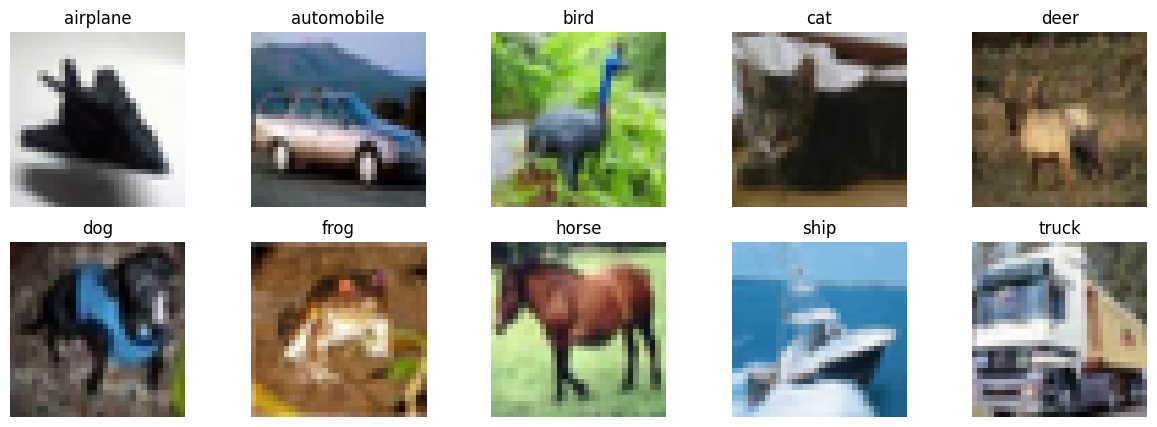

In [6]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Вибір по одному зображенню для кожного класу
selected_images = []
selected_labels = []

for class_index in range(10):
    # Знаходження першого елемента для кожного класу
    index = np.where(np.argmax(y_train, axis=1) == class_index)[0][0]
    selected_images.append(X_train[index])
    selected_labels.append(y_train[index])

# Відображення зображень
plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(selected_images[i])
    plt.title(class_names[np.argmax(selected_labels[i])])
    plt.axis('off')

plt.show()

### Створимо структуру моделі CNN

### Функція втрат (loss function)
Використання `categorical_crossentropy` як функції втрат для моделі з 10 класами має наступні _переваги_ та _недоліки_:

_*Переваги*_:

- `categorical_crossentropy` є стандартною функцією втрат для багатокласової класифікації.  
Вона вимірює різницю між двома ймовірнісними розподілами: істинними мітками та передбаченнями моделі.
- Вона надає велику помилку, коли модель передбачає неправильний клас з високою впевненістю,  
що допомагає моделі швидше навчитися.  

_*Недоліки*_:

- Якщо деякі класи є незбалансованими, `categorical_crossentropy` може призвести до того,  
що модель буде занадто  зосереджена на більш поширених класах і ігноруватиме рідкісні класи.
- Вона може бути чутливою до шуму в мітках, оскільки вона штрафує навіть малі відхилення від істинних міток.

In [7]:
model = models.Sequential()

# Додавання згорткових шарів та шарів пулінгу
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))  # Додаємо Dropout

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))  # Додаємо Dropout

model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Додавання повнозв'язних шарів
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))  # Додаємо Dropout
model.add(layers.Dense(10, activation='softmax'))  # 10 класів виводу

# Компіляція моделі
# sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
# model.compile(optimizer=sgd,
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])



# Оптимізатор Adam

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Створимо клас Callback`у

In [8]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') is not None and logs.get('val_accuracy') > 0.95:
            self.model.stop_training = True   
            print(f'\n\nAccuracy моделі на тестових даних > 95 %, зупинка навчання після епохи № {epoch+1}')

### Навчаємо модель (150 епох або Accuracy валідаційних даних > 95 %)

In [9]:
callbacks = myCallback()

try:
    model = models.load_model('CNN_model.keras')
except:
    history = model.fit(X_train, y_train, 
                        epochs=150, 
                        batch_size=batch_size, 
                        validation_data=(X_val, y_val),
                        callbacks=[callbacks])
    model.save('CNN_model.keras') # Зберігаємо модель


# print(f'Введіть 0 для створення моделі, 1 для читання з файлу')
# chose = int(input('Введіть 0 для створення моделі, 1 для читання з файлу:  '))
# print(f'Введено: {chose}\n')

# if chose == 1:
#     model = models.load_model('CNN_model.keras')
# else:
#     history = model.fit(X_train, y_train, 
#                         epochs=150, 
#                         batch_size=batch_size, 
#                         validation_data=(X_val, y_val),
#                         callbacks=[callbacks])
#     model.save('CNN_model.keras') # Зберігаємо модель

Epoch 1/150
1563/1563 [==============================] - 66s 39ms/step - loss: 1.7596 - accuracy: 0.3466 - val_loss: 1.4314 - val_accuracy: 0.5006
Epoch 2/150
1563/1563 [==============================] - 55s 35ms/step - loss: 1.4282 - accuracy: 0.4890 - val_loss: 1.2293 - val_accuracy: 0.5632
Epoch 3/150
1563/1563 [==============================] - 55s 35ms/step - loss: 1.2998 - accuracy: 0.5379 - val_loss: 1.1151 - val_accuracy: 0.6078
Epoch 4/150
1563/1563 [==============================] - 56s 36ms/step - loss: 1.2183 - accuracy: 0.5725 - val_loss: 1.0496 - val_accuracy: 0.6292
Epoch 5/150
1563/1563 [==============================] - 56s 36ms/step - loss: 1.1586 - accuracy: 0.5930 - val_loss: 1.0628 - val_accuracy: 0.6302
Epoch 6/150
1563/1563 [==============================] - 57s 36ms/step - loss: 1.1126 - accuracy: 0.6084 - val_loss: 1.0092 - val_accuracy: 0.6444
Epoch 7/150
1563/1563 [==============================] - 57s 37ms/step - loss: 1.0697 - accuracy: 0.6266 - val_loss: 0

### Тестуємо модель та знаходимо метрики

In [10]:
test_results = model.evaluate(X_test, y_test, verbose=0)

test_accuracy = test_results[1]
predictions = np.argmax(model.predict(X_test, verbose=0), axis=1)
test_precision = precision_score(np.argmax(y_test, axis=1), predictions, average='weighted')
test_recall = recall_score(np.argmax(y_test, axis=1), predictions, average='weighted')
test_f1_score = f1_score(np.argmax(y_test, axis=1), predictions, average='weighted')

print(f'Accuracy  моделі на тестових даних: {test_accuracy * 100:.2f} %')
print(f'Precision моделі на тестових даних: {test_precision * 100:.2f} %')
print(f'Recall    моделі на тестових даних: {test_recall * 100:.2f} %')
print(f'F1-score  моделі на тестових даних: {test_f1_score * 100:.2f} %')

Accuracy  моделі на тестових даних: 76.58 %
Precision моделі на тестових даних: 76.42 %
Recall    моделі на тестових даних: 76.58 %
F1-score  моделі на тестових даних: 76.34 %


### Будуємо ROC-криву для кожного класу

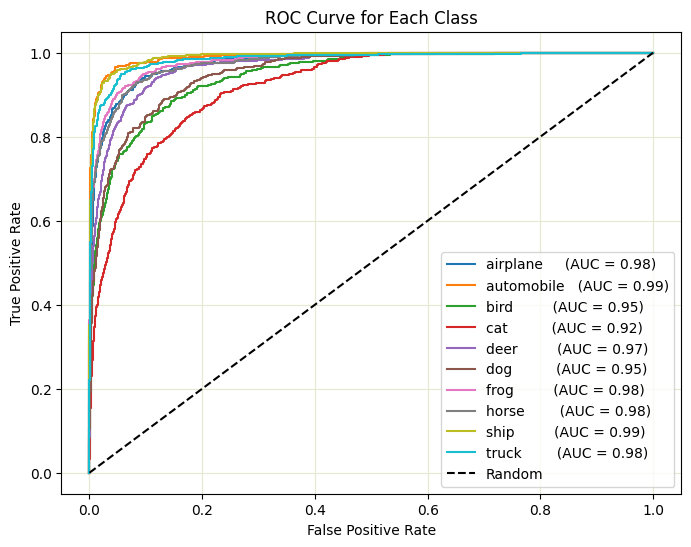

In [11]:
predictions = model.predict(X_test, verbose=0)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Побудова ROC-кривих
plt.figure(figsize=(8, 6))

for i in range(10):
    label = f'{class_names[i]:<12} (AUC = {roc_auc[i]:.2f})'
    plt.plot(fpr[i], tpr[i], label=label)

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc='best')
plt.grid(c='#E7E8D2')
plt.show()

### Виводимо час відпрацювання програми та характеристики ПК

In [12]:
elapsed_time = time.time() - start_timer
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)

if hours > 0:
    print(f'Час роботи: {int(hours)} год, {int(minutes)} хв, {int(seconds)} сек')
elif minutes > 0:
    print(f'Час роботи: {int(minutes)} хв, {int(seconds)} сек')
else:
    print(f'Час роботи: {int(seconds)} сек')
print(f'Процесор:   AMD Ryzen 5 3550H with Radeon Vega')
print(f'ОЗП:        8.00 ГБ')
print(f'ОС:         Windows 10 Pro')

Час роботи: 2 год, 22 хв, 36 сек
Процесор:   AMD Ryzen 5 3550H with Radeon Vega
ОЗП:        8.00 ГБ
ОС:         Windows 10 Pro
